In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import load_model
import os
import gymnasium as gym
import pandas as pd
import matplotlib.ticker as ticker

In [2]:
@tf.keras.utils.register_keras_serializable()
class DQN(tf.keras.models.Model):
    def __init__(self, hidden_layers, output_layer):
        super(DQN, self).__init__()
        self.hidden_layers = hidden_layers
        self.output_layer = output_layer

    def call(self, inputs):
        x = inputs
        for layer in self.hidden_layers:
            x = layer(x)
        return self.output_layer(x)

    def get_config(self):
        config = {
            "hidden_layers": self.hidden_layers,
            "output_layer": self.output_layer,
        }
        return config

    @classmethod
    def from_config(cls, config):
        hidden_layers = []
        for layer in config["hidden_layers"]:
            hidden_layers.append(tf.keras.layers.Dense(**layer["config"]))
        output_layer = tf.keras.layers.Dense(**config["output_layer"]["config"])
        return cls(hidden_layers, output_layer)

In [3]:
def save_episode_rewards_metrics(results_dir, model_name, episode_rewards):
    if episode_rewards is None:
        return

    sns.lineplot(data=episode_rewards)
    plt.title("Episode Rewards")
    plt.savefig(f"{results_dir}/{model_name}_episode_rewards.png")
    plt.show()

    episode_rewards_means = np.array(episode_rewards).reshape(-1, 100).mean(axis=1)
    sns.lineplot(data=episode_rewards_means)
    plt.title("Episode Rewards Means")
    # Change x-axis scale
    scale_x = 1e2
    ticks_x = ticker.FuncFormatter(lambda x, pos: "{0:g}".format(int(x * scale_x)))
    plt.gca().xaxis.set_major_formatter(ticks_x)
    plt.savefig(f"{results_dir}/{model_name}_episode_rewards_means.png")
    plt.show()


def save_metrics(results_dir, model_name, metrics: dict):
    episode_rewards = metrics.get("episode_rewards")
    save_episode_rewards_metrics(results_dir, model_name, episode_rewards)

In [4]:
mountain_env = gym.make("MountainCar-v0")


def reshape_reward(reward, next_state, current_state, speed_weight):
    return reward + speed_weight * (np.abs(next_state[1]) - np.abs(current_state[1]))


def evaluate_mountain_model(model, speed_weight, evaluation_episodes=100):
    rewards, reshaped_rewards = [], []
    for _ in range(evaluation_episodes):
        state, _ = mountain_env.reset()
        done, truncated = False, False
        accumulated_reward, accumulated_reshaped_reward = 0, 0
        while not done and not truncated:
            state_in = tf.expand_dims(state, axis=0)
            action = tf.argmax(model(state_in)[0]).numpy()
            next_state, reward, done, truncated, _ = mountain_env.step(action)
            accumulated_reward += reward
            accumulated_reshaped_reward += reshape_reward(
                reward, next_state, state, speed_weight
            )
            state = next_state
        rewards.append(accumulated_reward)
        reshaped_rewards.append(accumulated_reshaped_reward)
    return rewards, reshaped_rewards

In [5]:
mountain_models_path = "mountain/models"
mountain_metrics_path = "mountain/metrics"
mountain_hyperparams_path = "mountain/hyperparams"
mountain_results_path = "mountain/results"


def load_mountain_model_data(model_name_with_extension):
    model_name = model_name_with_extension.split(".")[0]
    metrics = np.load(
        os.path.join(mountain_metrics_path, f"{model_name}_metrics.npy"),
        allow_pickle=True,
    ).item()
    hyperparams = np.load(
        os.path.join(mountain_hyperparams_path, f"{model_name}_hyperparams.npy"),
        allow_pickle=True,
    ).item()
    speed_weight = hyperparams.get("speed_weight", 10)
    model = load_model(
        os.path.join(mountain_models_path, f"{model_name_with_extension}")
    )

    return model_name, metrics, hyperparams, speed_weight, model

2024-06-15_12-31-16_dqn_mountaincar


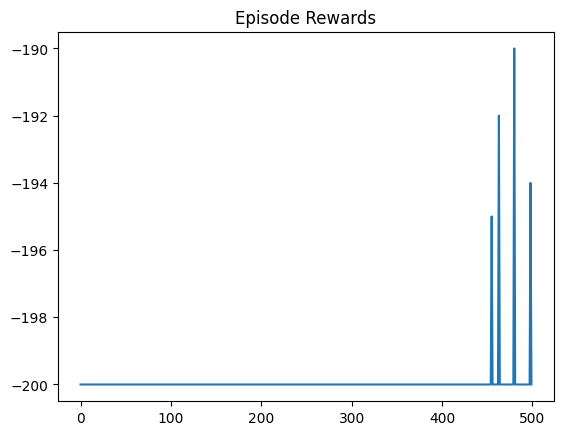

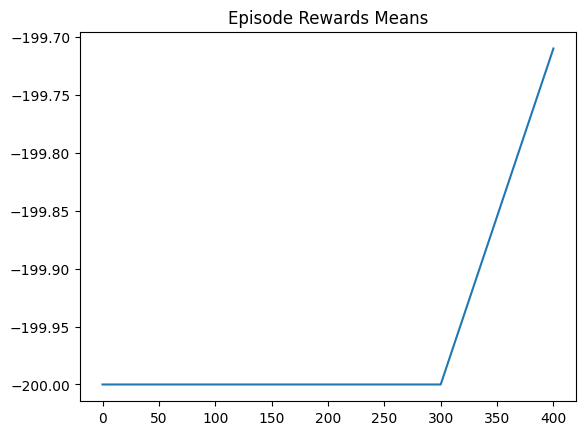

2024-06-15_13-02-52_dqn_mountaincar


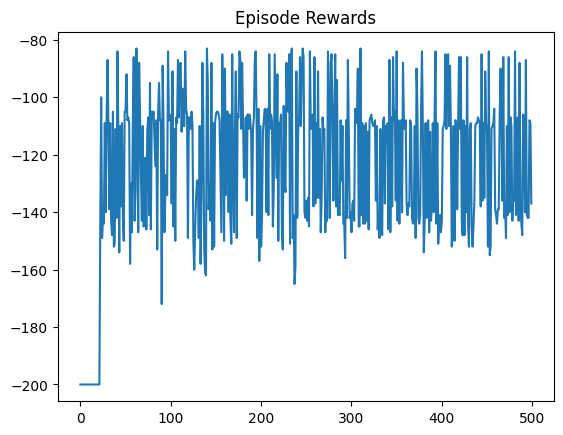

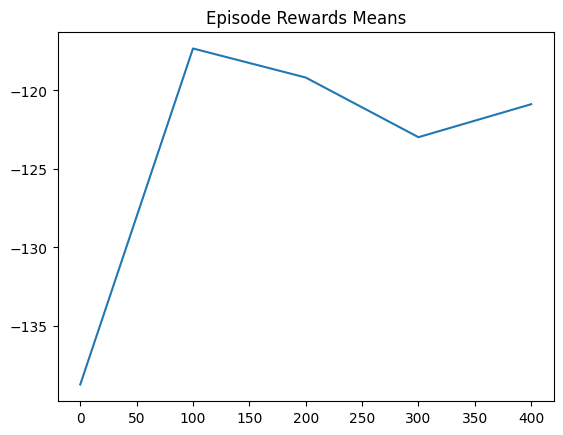

2024-06-15_13-39-22_dqn_mountaincar


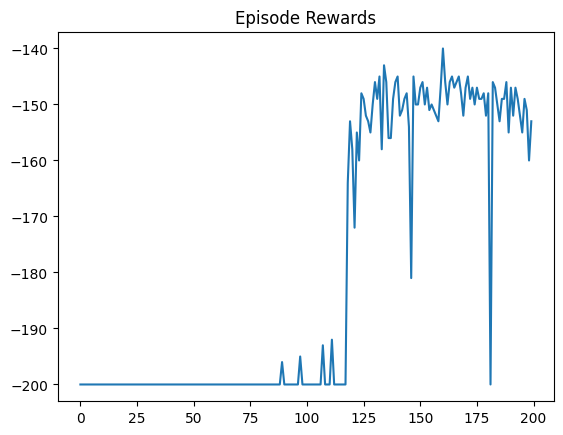

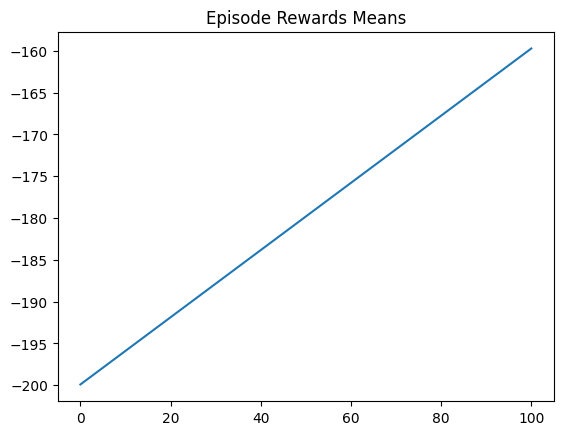

2024-06-15_13-45-28_dqn_mountaincar


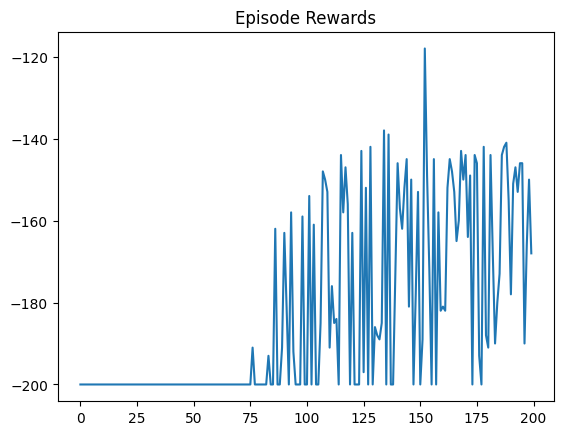

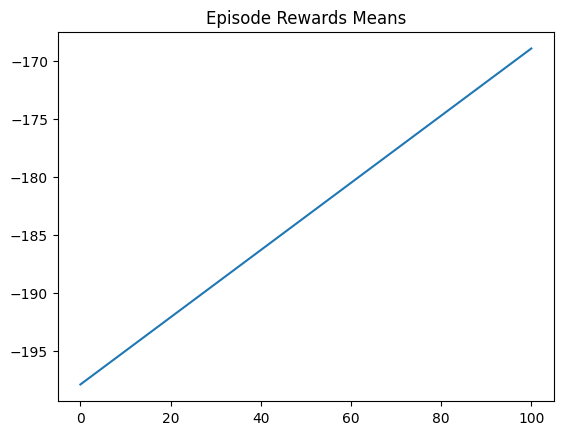

2024-06-15_12-43-21_dqn_mountaincar


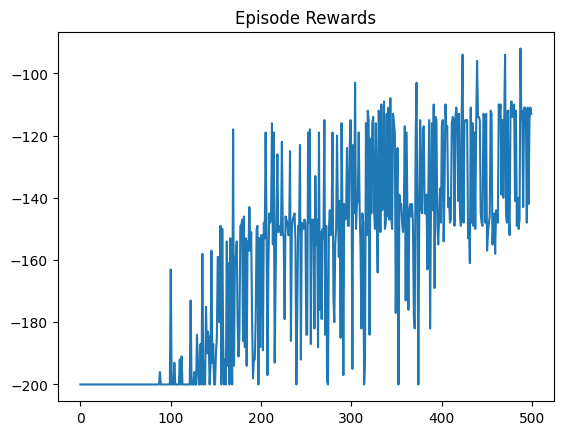

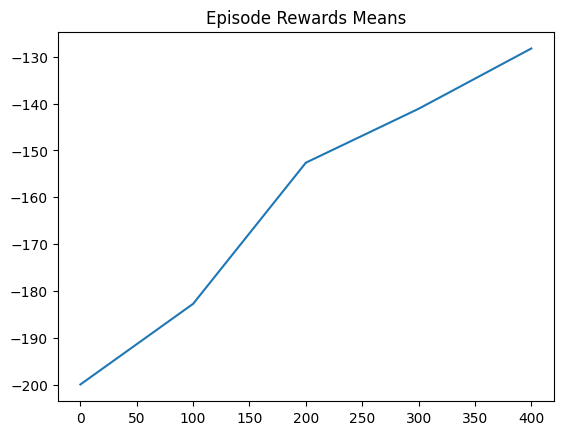

2024-06-15_13-00-05_dqn_mountaincar


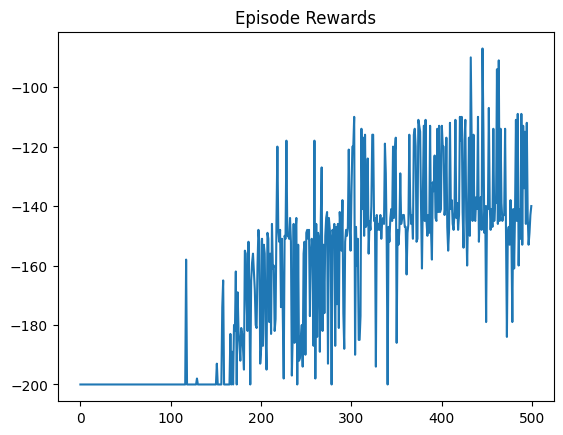

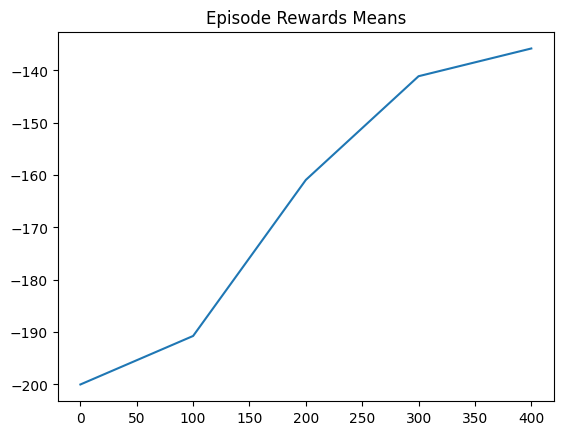

2024-06-15_08-13-32_dqn_mountaincar


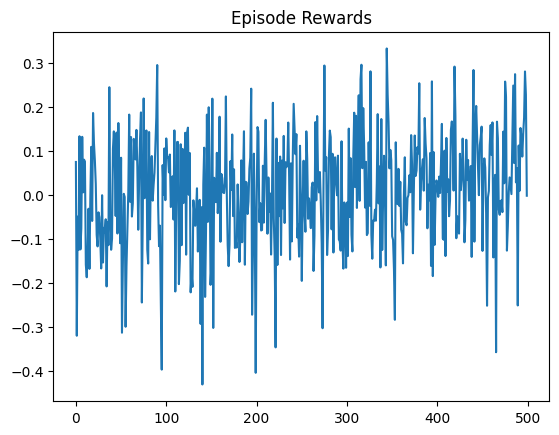

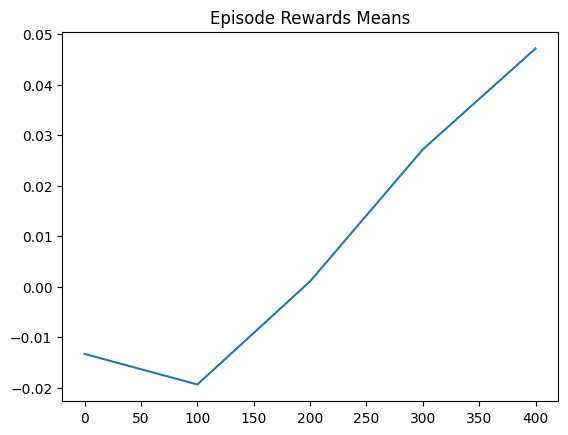

2024-06-15_13-20-27_dqn_mountaincar


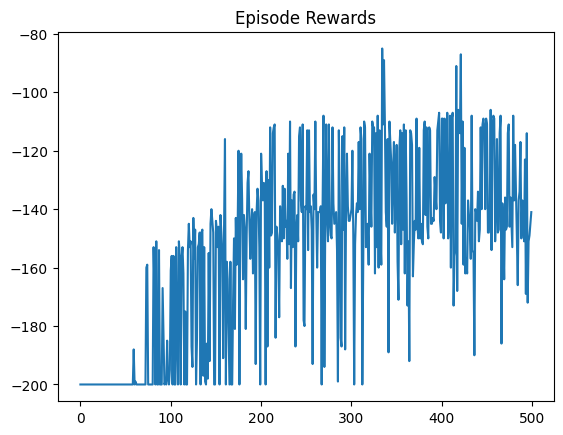

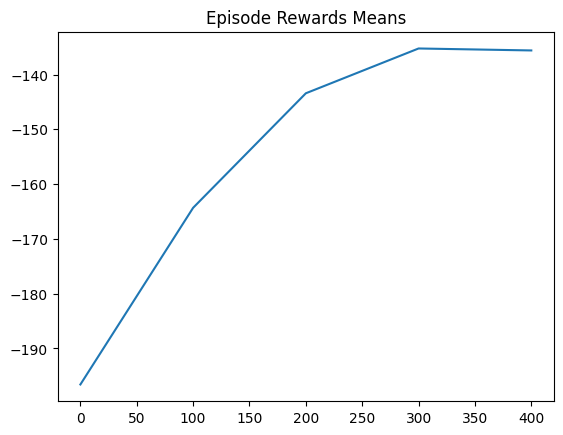

2024-06-15_10-54-10_dqn_mountaincar


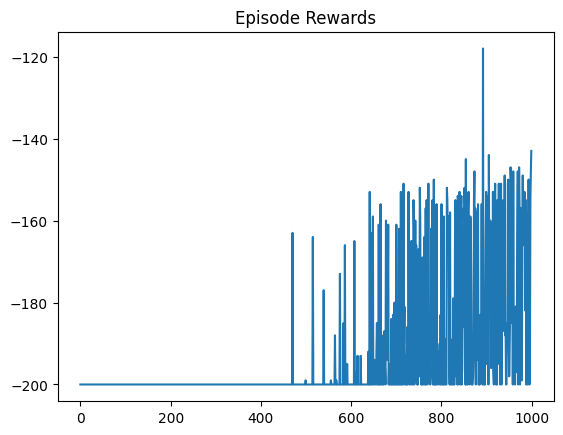

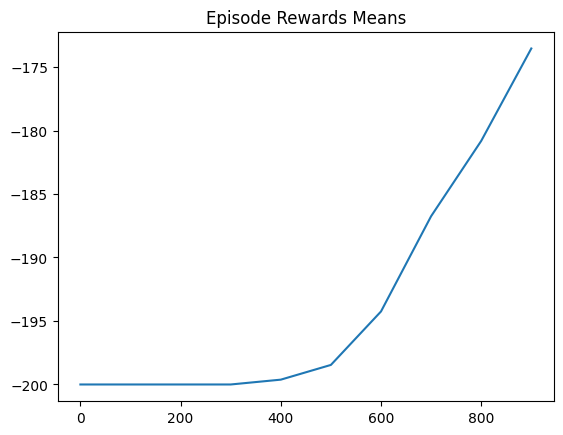

2024-06-15_13-41-53_dqn_mountaincar


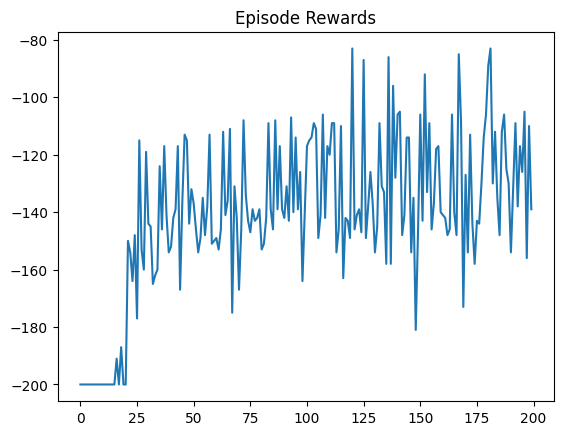

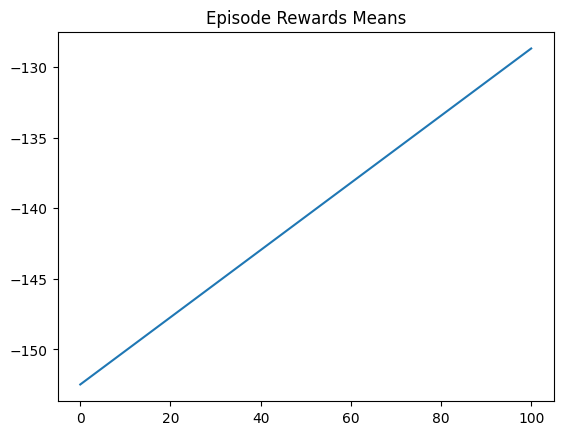

2024-06-15_12-23-27_dqn_mountaincar


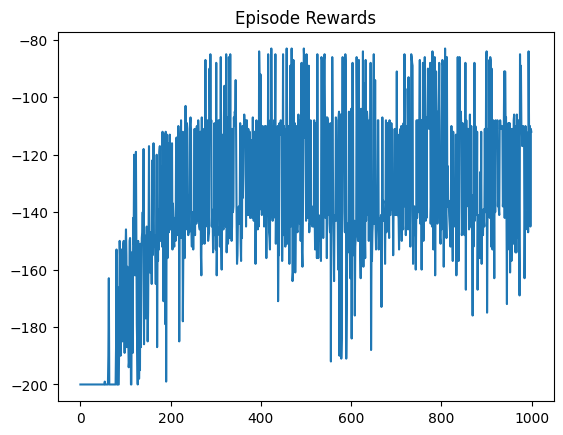

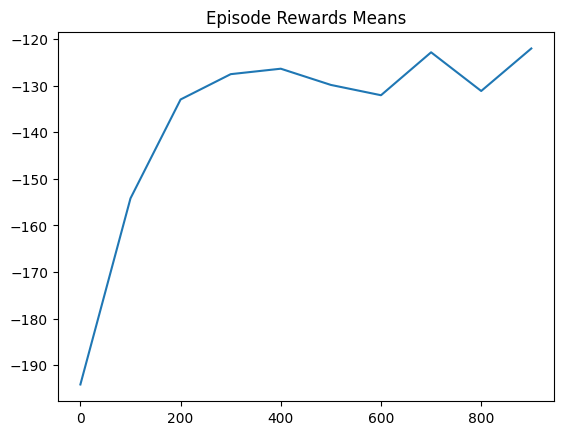

2024-06-15_11-21-25_dqn_mountaincar


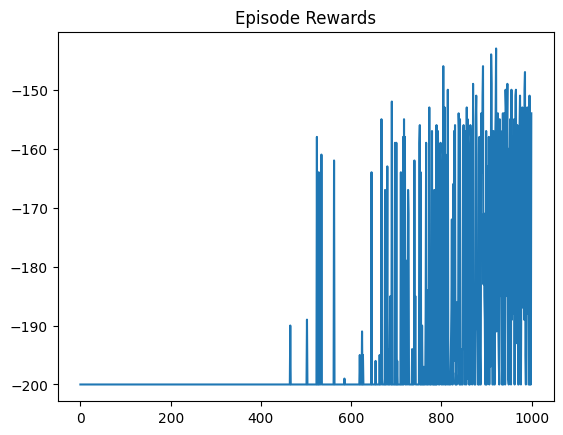

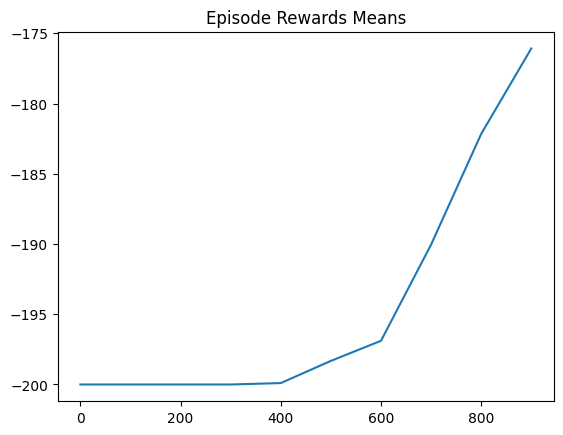

2024-06-15_13-45-47_dqn_mountaincar


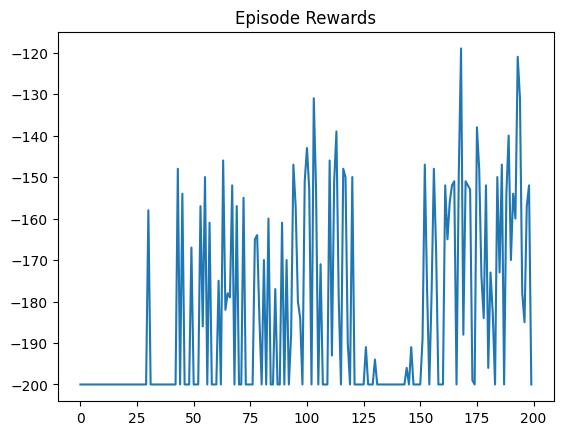

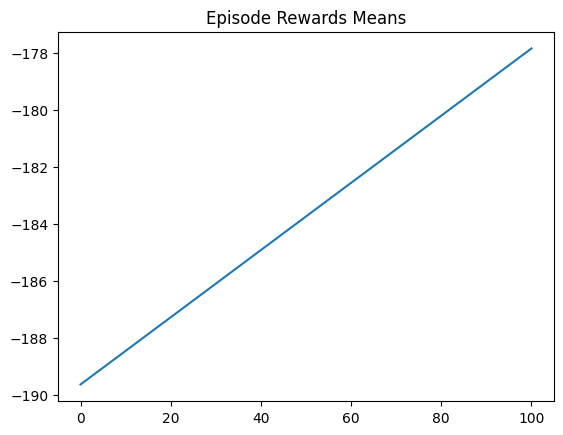

2024-06-15_11-01-53_dqn_mountaincar


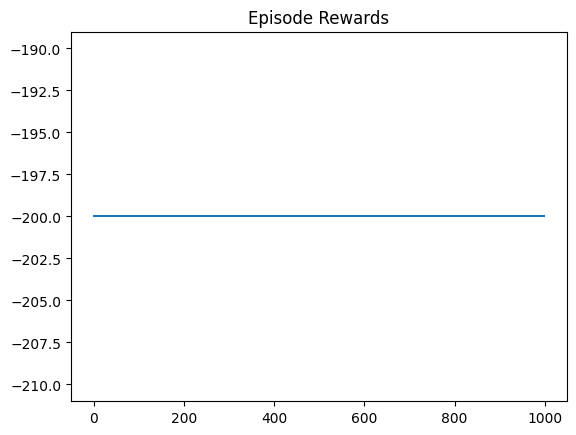

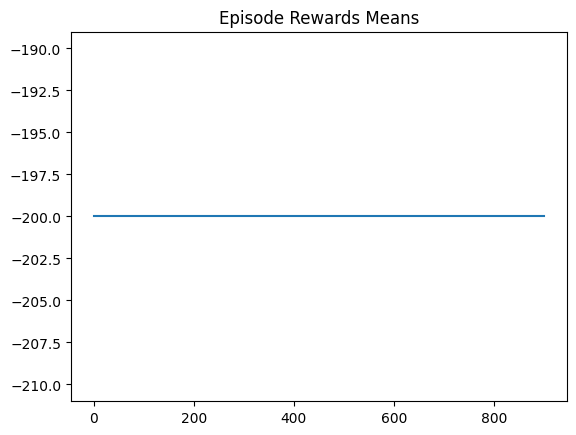

2024-06-15_12-35-51_dqn_mountaincar


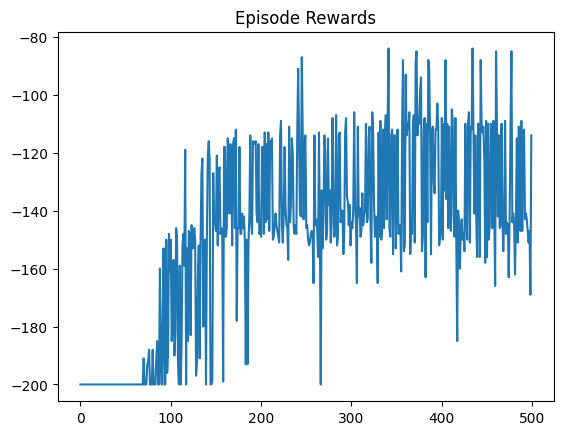

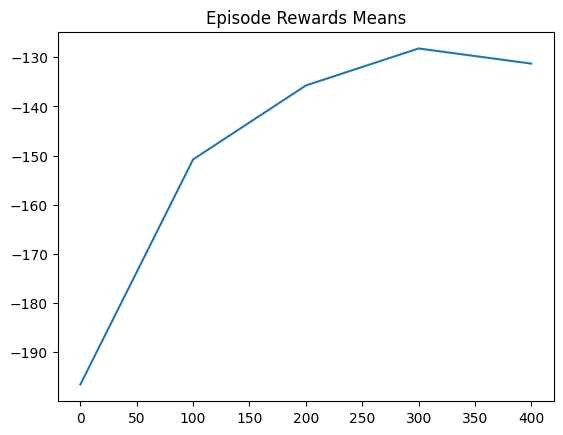

2024-06-15_16-46-16_dqn_mountaincar


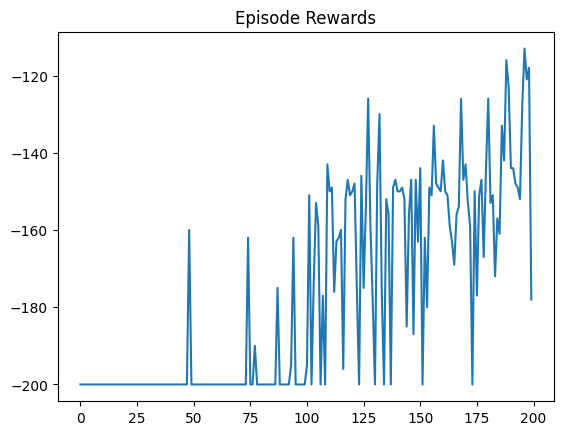

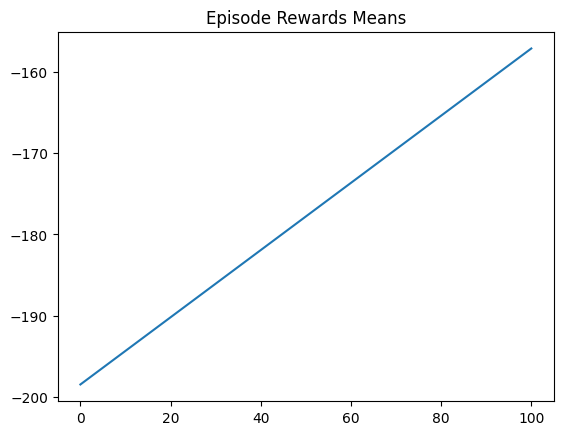

2024-06-15_12-16-56_dqn_mountaincar


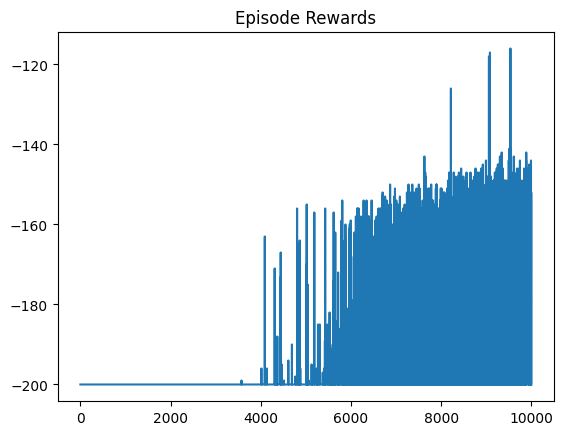

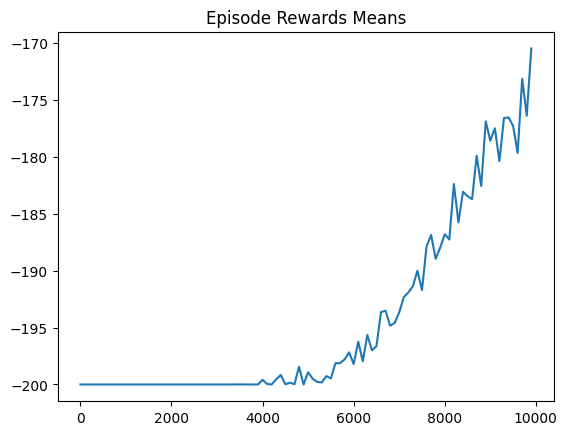

2024-06-15_13-48-51_dqn_mountaincar


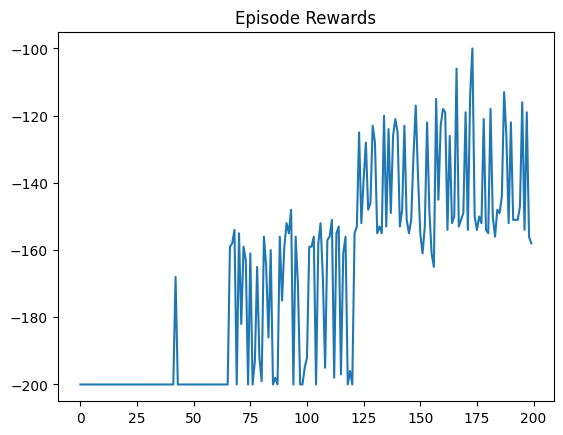

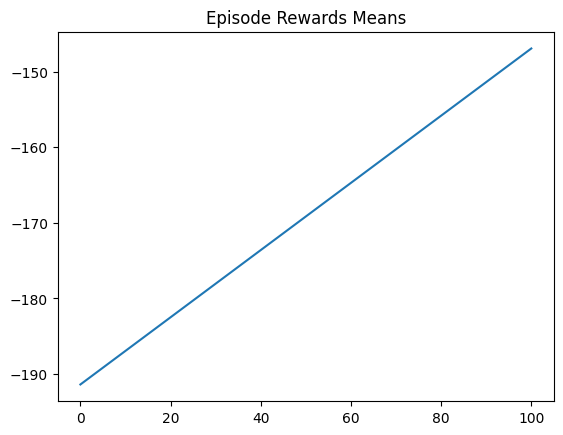

2024-06-15_12-43-26_dqn_mountaincar


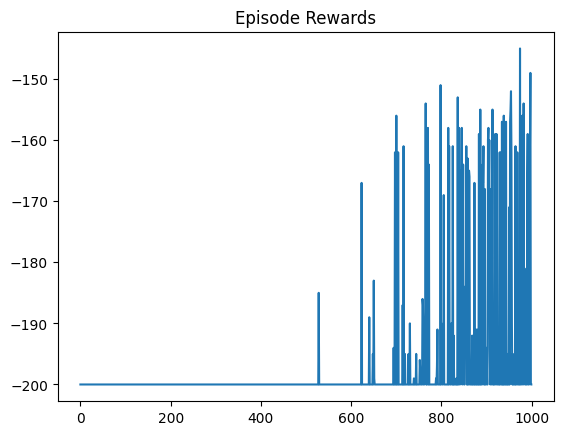

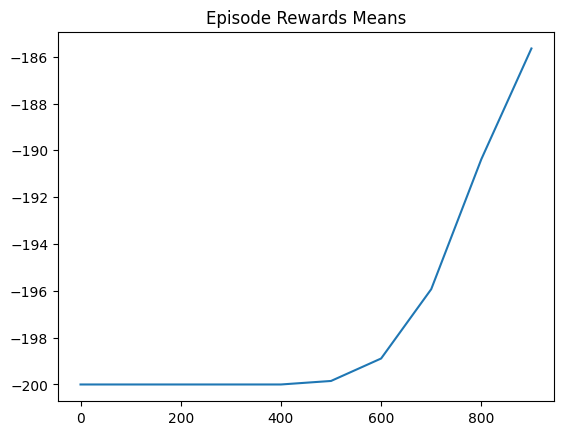

2024-06-15_13-36-42_dqn_mountaincar


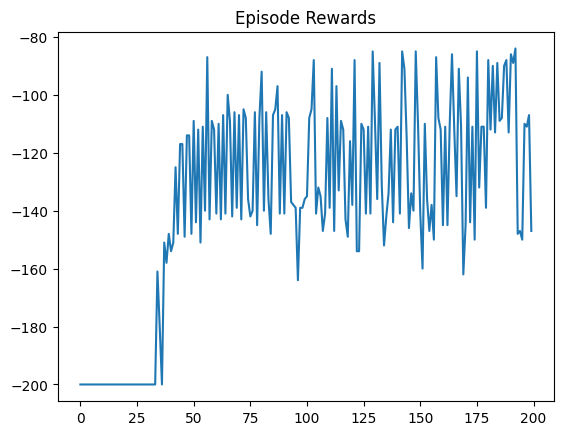

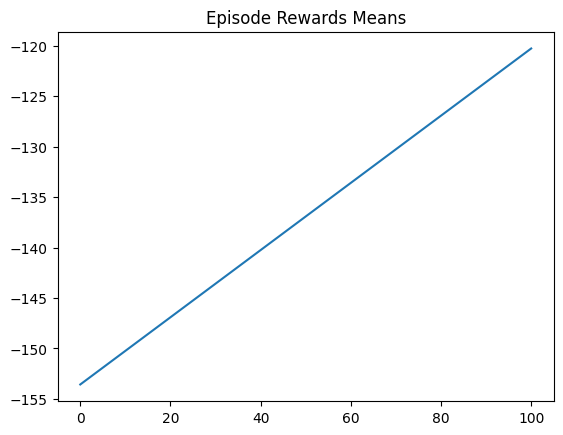

2024-06-15_11-57-24_dqn_mountaincar


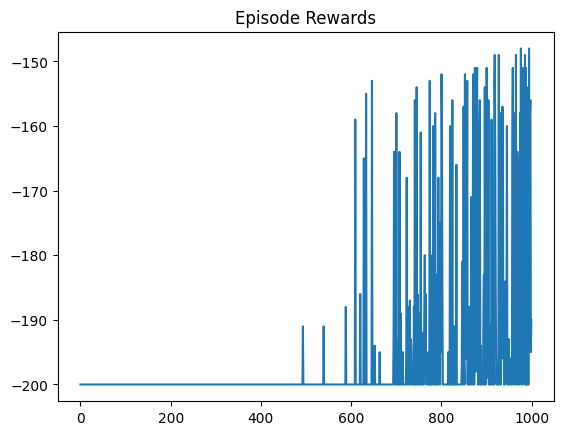

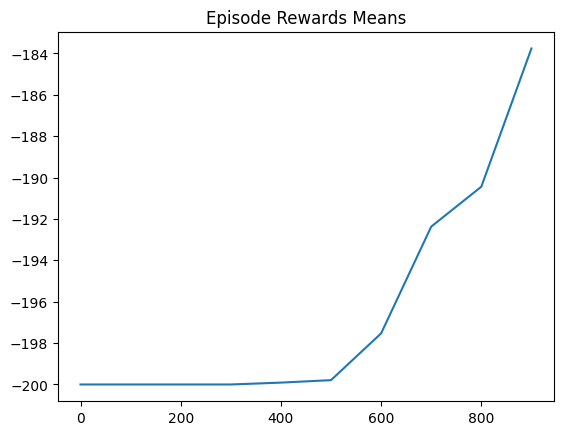

2024-06-15_13-56-21_dqn_mountaincar


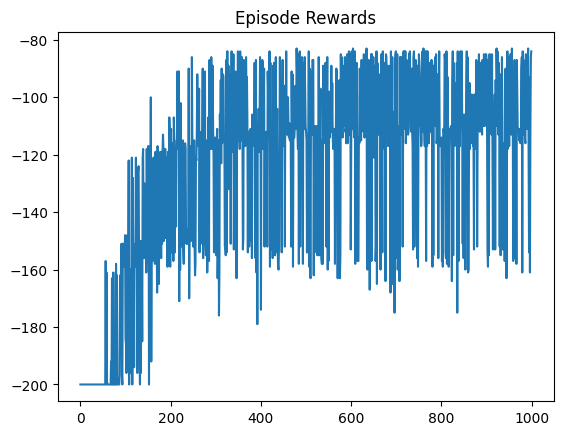

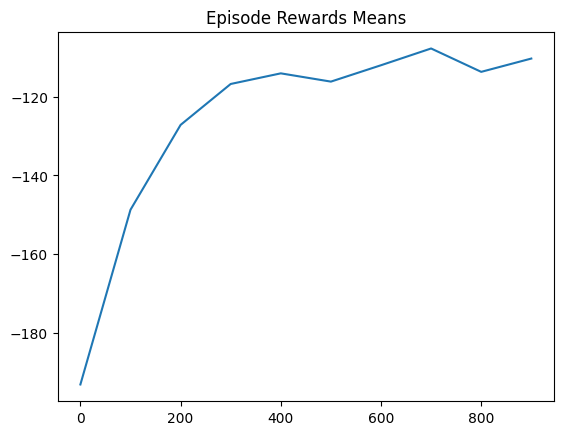

In [6]:
mountain_models_paths = os.listdir(mountain_models_path)

data = pd.DataFrame()

for model_name_with_extension in mountain_models_paths:
    model_name, metrics, hyperparams, speed_weight, model = load_mountain_model_data(
        model_name_with_extension
    )
    print(model_name)
    evaluate_rewards, evaluate_reshaped_rewards = evaluate_mountain_model(
        model, speed_weight, 10
    )
    units_per_layer = [layer.units for layer in model.hidden_layers]
    activation_per_layer = [layer.activation.__name__ for layer in model.hidden_layers]
    data = data._append(
        {
            "model": model_name,
            "evaluate_max_reward": np.max(evaluate_rewards),
            "evaluate_rewards_mean": np.mean(evaluate_rewards),
            "evaluate_rewards_std": np.std(evaluate_rewards),
            "hidden_layers": len(model.hidden_layers),
            "units_per_layer": units_per_layer,
            "activation_per_layer": activation_per_layer,
            "output_layer_activation": model.output_layer.activation.__name__,
            **hyperparams,
        },
        ignore_index=True,
    )
    save_metrics(mountain_results_path, model_name, metrics)

data.to_csv("mountain/results.csv")

In [7]:
cartpole_env = gym.make("CartPole-v1")


def evaluate_cartpole_model(model, evaluation_episodes=1):
    rewards = []
    for _ in range(evaluation_episodes):
        state, _ = cartpole_env.reset()
        done, truncated = False, False
        accumulated_reward = 0
        while not done and not truncated:
            state_in = tf.expand_dims(state, axis=0)
            action = tf.argmax(model(state_in)[0]).numpy()
            next_state, reward, done, truncated, _ = cartpole_env.step(action)
            accumulated_reward += reward
            state = next_state
        rewards.append(accumulated_reward)
    return rewards

In [8]:
cartpole_models_path = "pole/models"
cartpole_metrics_path = "pole/metrics"
cartpole_hyperparams_path = "pole/hyperparams"
cartpole_results_path = "pole/results"


def load_cartpole_model_data(model_name_with_extension):
    model_name = model_name_with_extension.split(".")[0]
    metrics = np.load(
        os.path.join(cartpole_metrics_path, f"{model_name}_metrics.npy"),
        allow_pickle=True,
    ).item()
    hyperparams = np.load(
        os.path.join(cartpole_hyperparams_path, f"{model_name}_hyperparams.npy"),
        allow_pickle=True,
    ).item()
    model = load_model(
        os.path.join(cartpole_models_path, f"{model_name_with_extension}")
    )

    return model_name, metrics, hyperparams, model

2024-06-13_17-34-57_dqn_cartpole


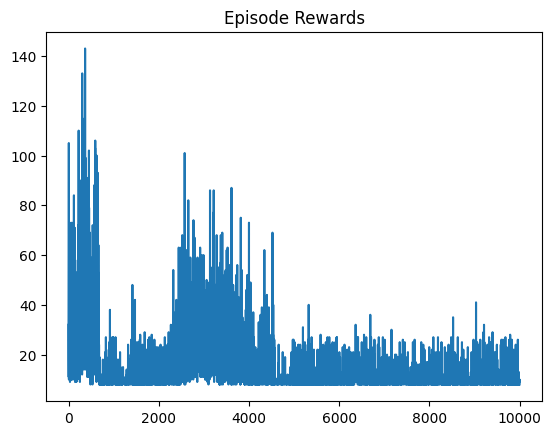

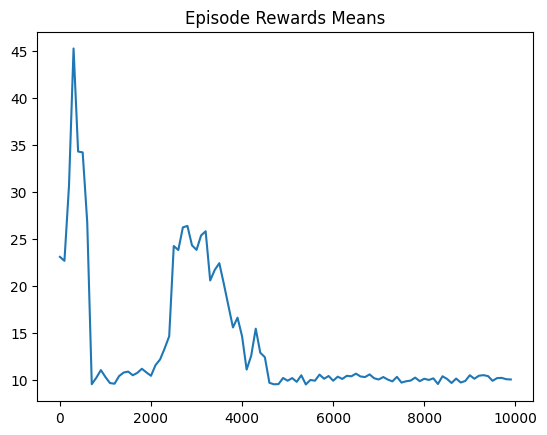

2024-06-14_00-20-45_dqn_cartpole


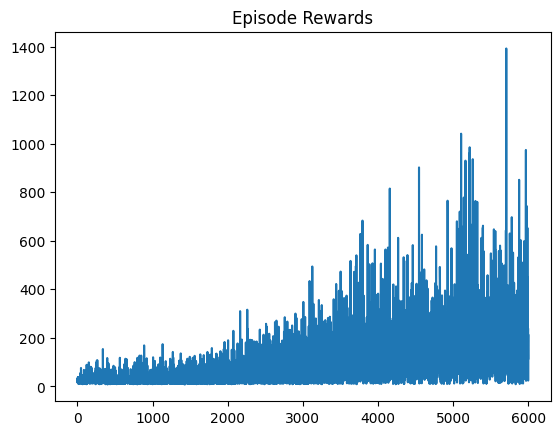

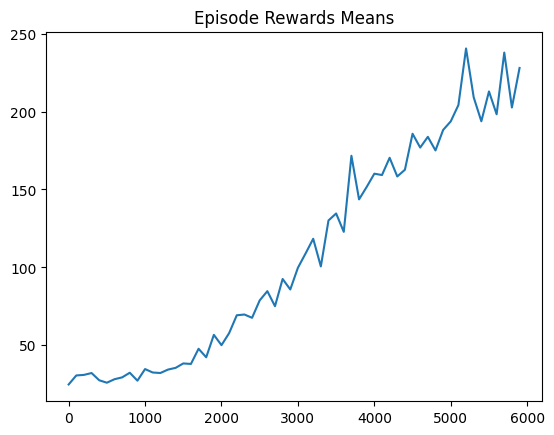

2024-06-13_21-08-24_dqn_cartpole


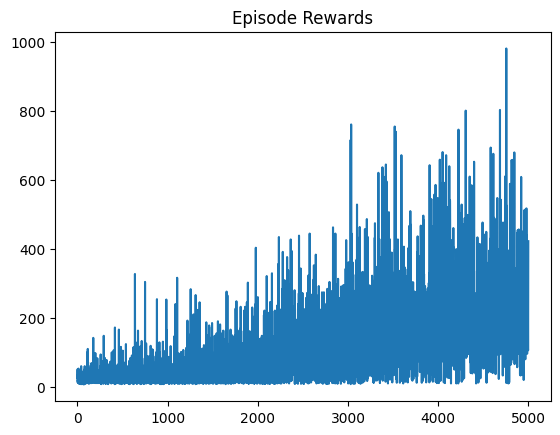

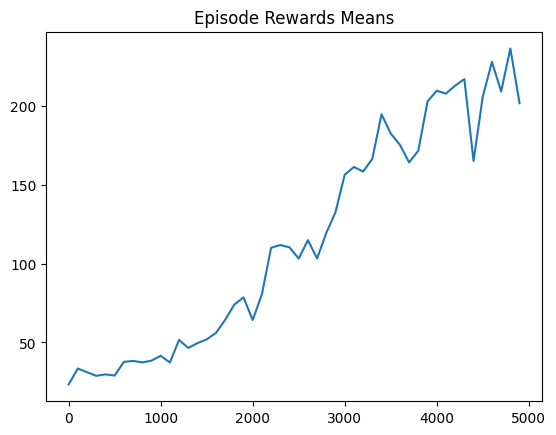

2024-06-14_09-34-50_dqn_cartpole


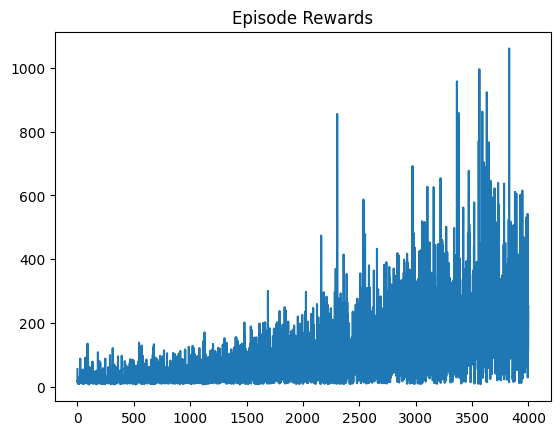

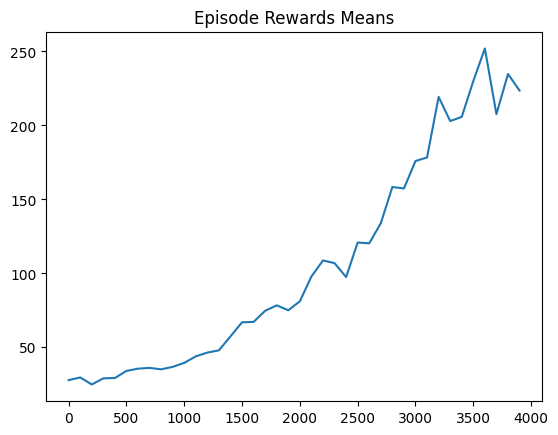

2024-06-13_18-59-17_dqn_cartpole


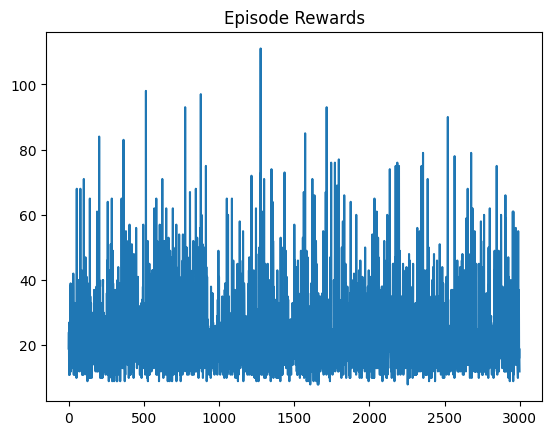

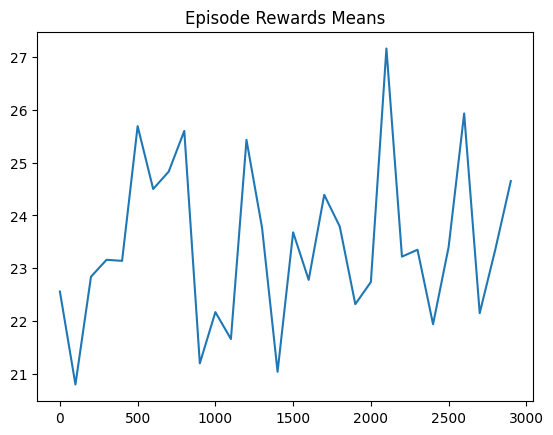

2024-06-14_17-31-42_dqn_cartpole


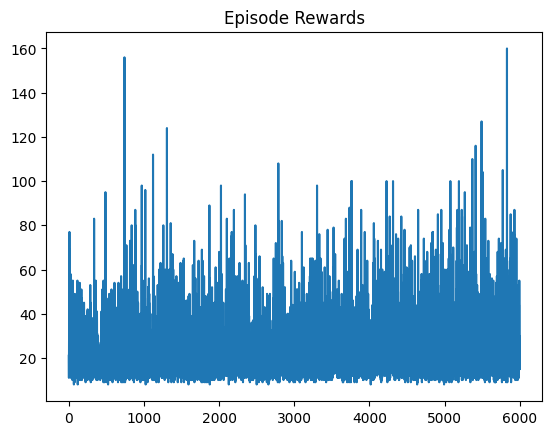

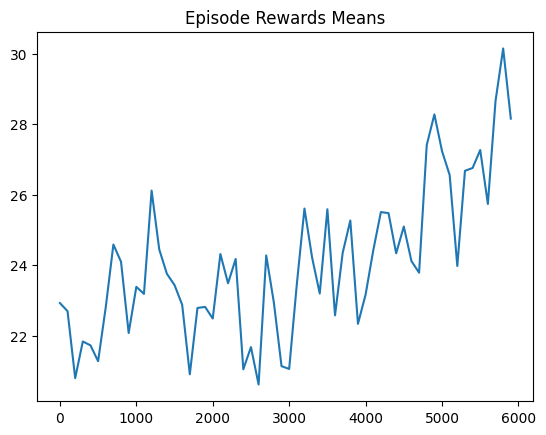

2024-06-14_18-54-27_dqn_cartpole


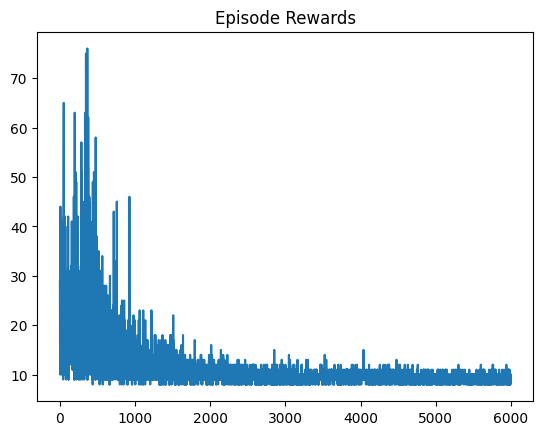

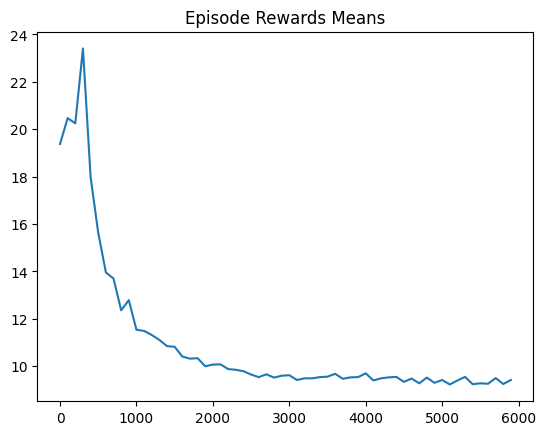

2024-06-14_18-17-10_dqn_cartpole


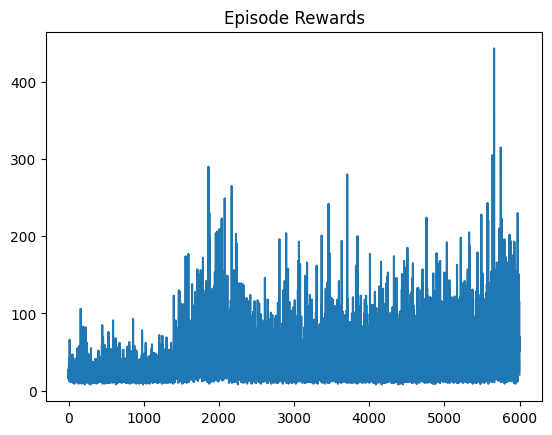

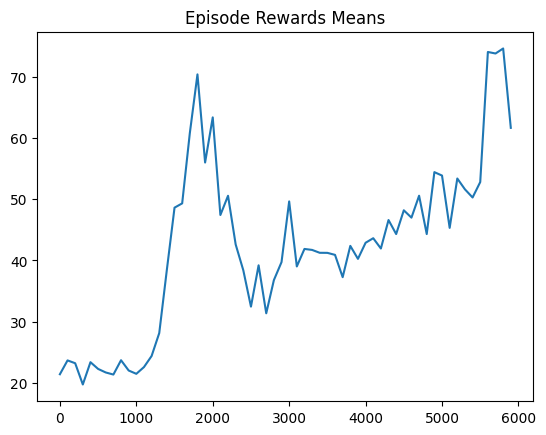

2024-06-13_18-42-33_dqn_cartpole


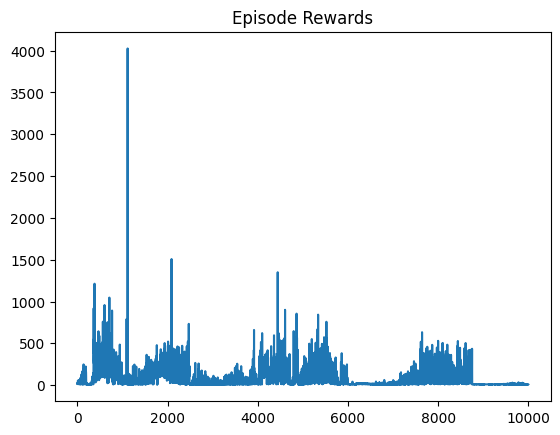

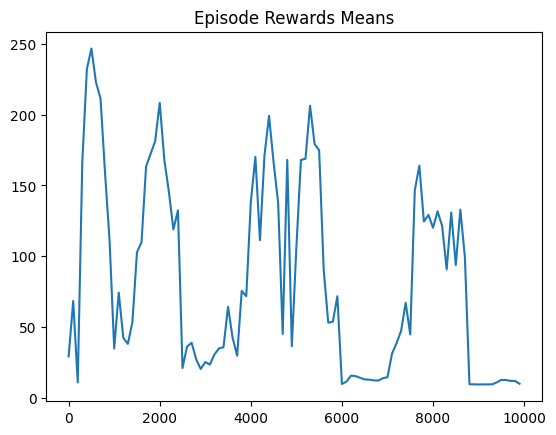

2024-06-13_23-08-40_dqn_cartpole


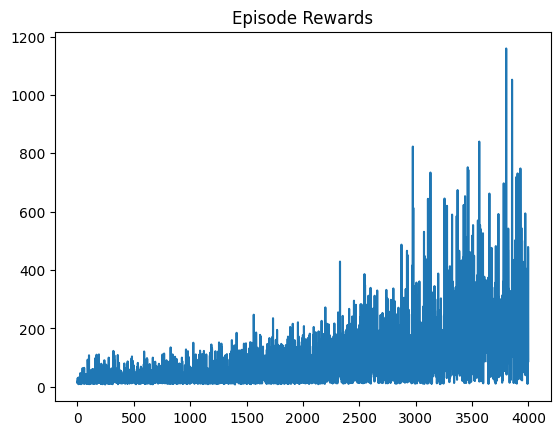

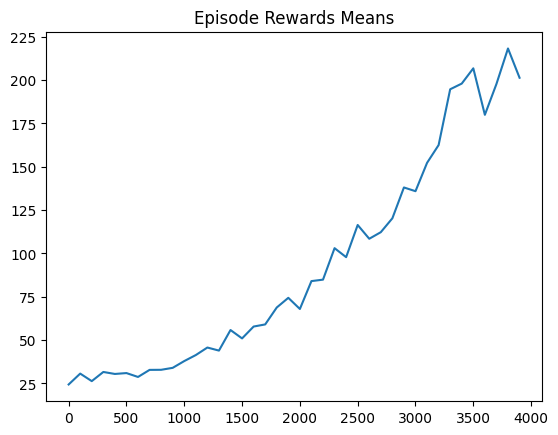

2024-06-14_16-42-26_dqn_cartpole


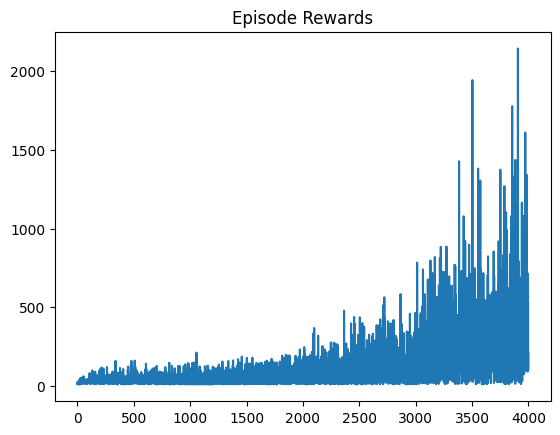

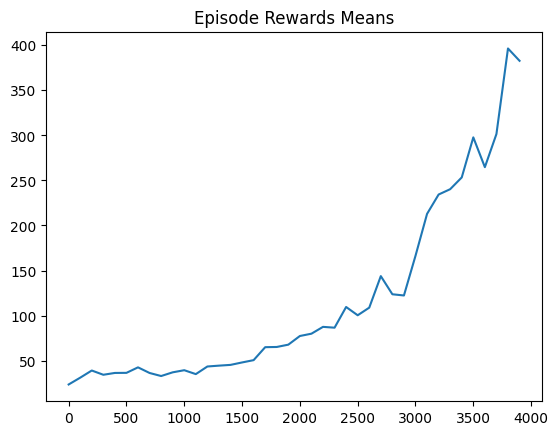

2024-06-15_00-29-02_dqn_cartpole


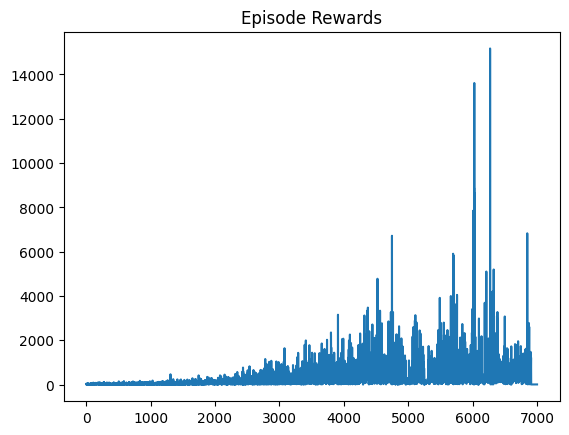

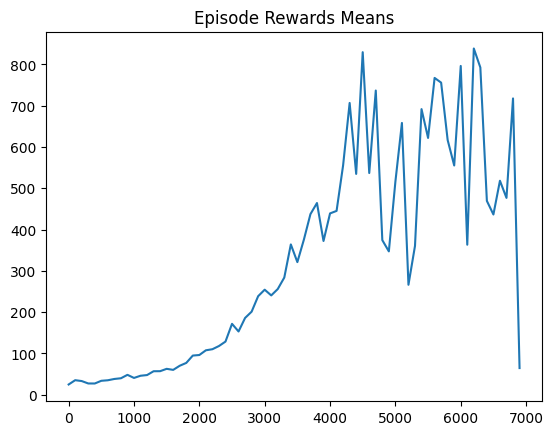

2024-06-13_18-50-05_dqn_cartpole


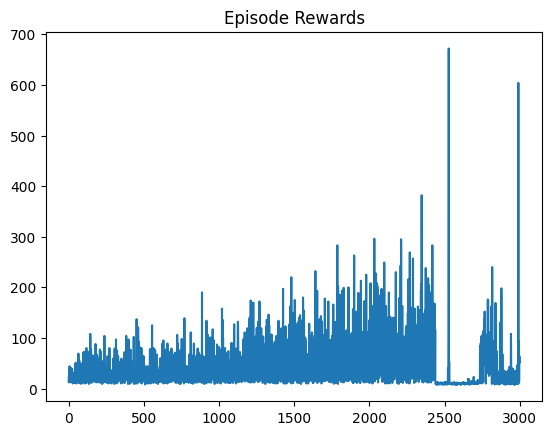

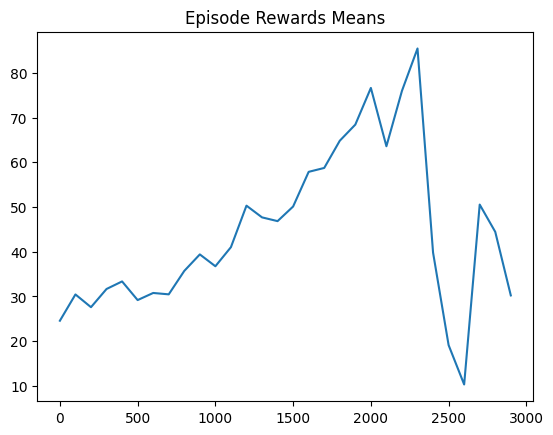

2024-06-14_18-50-42_dqn_cartpole


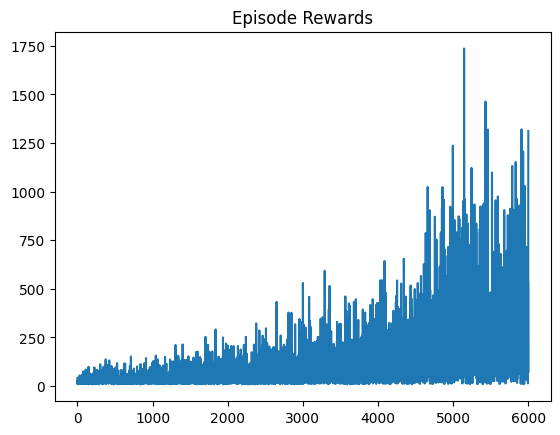

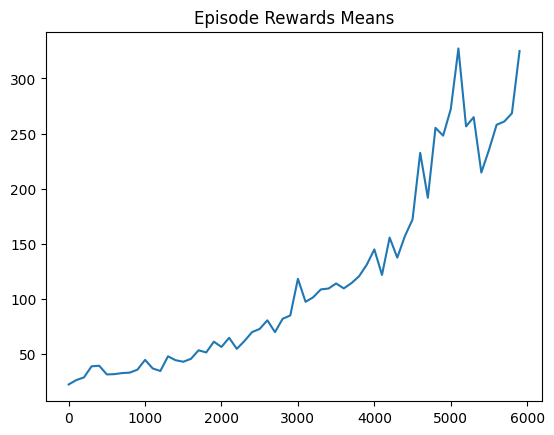

2024-06-13_19-11-27_dqn_cartpole


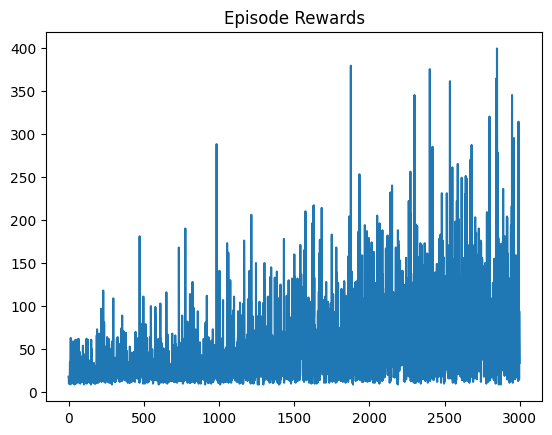

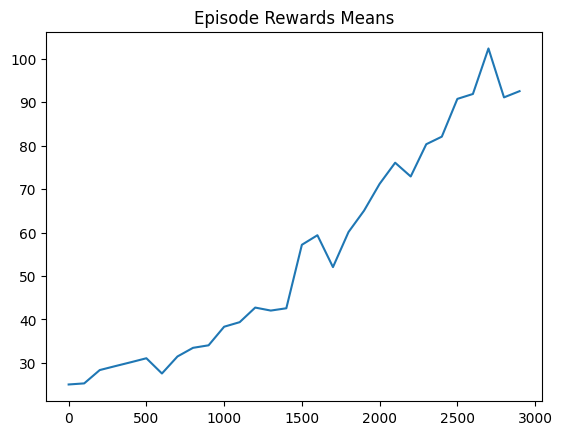

2024-06-14_13-15-56_dqn_cartpole


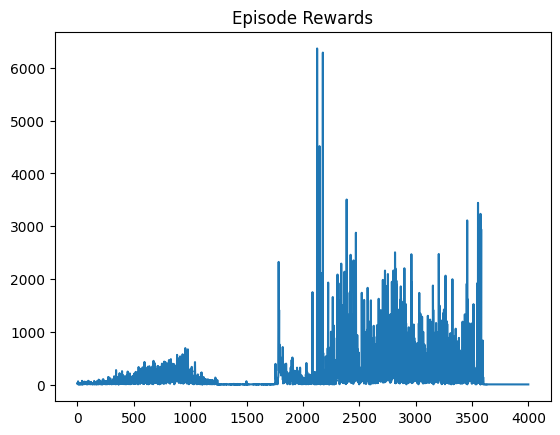

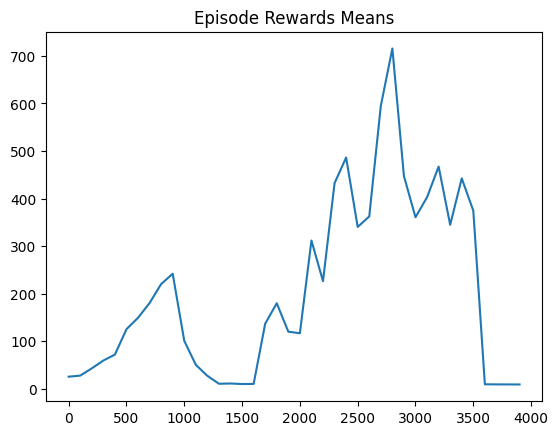

2024-06-14_15-38-10_dqn_cartpole


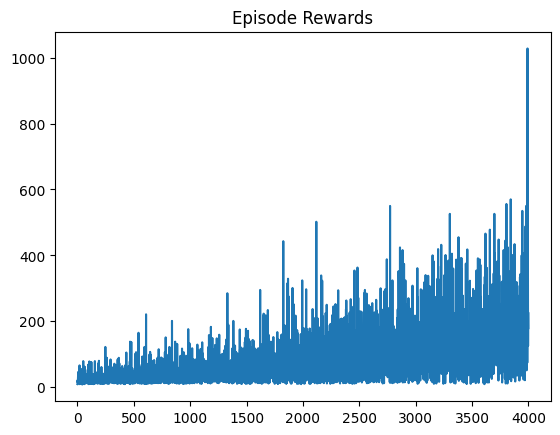

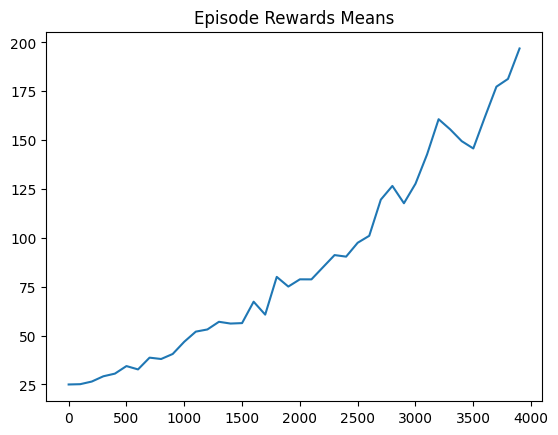

2024-06-13_18-56-41_dqn_cartpole


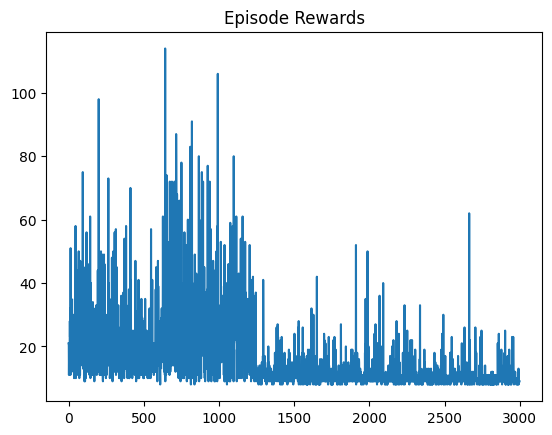

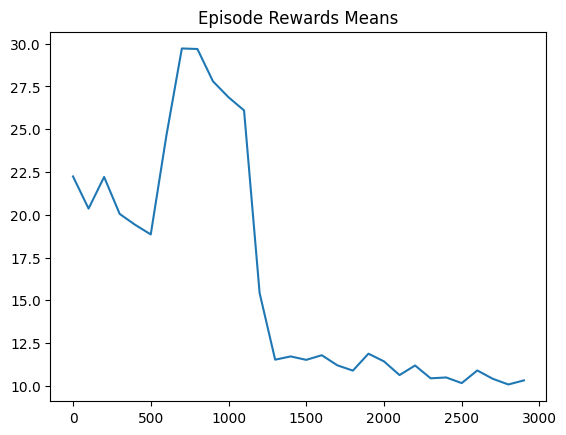

2024-06-14_11-09-14_dqn_cartpole


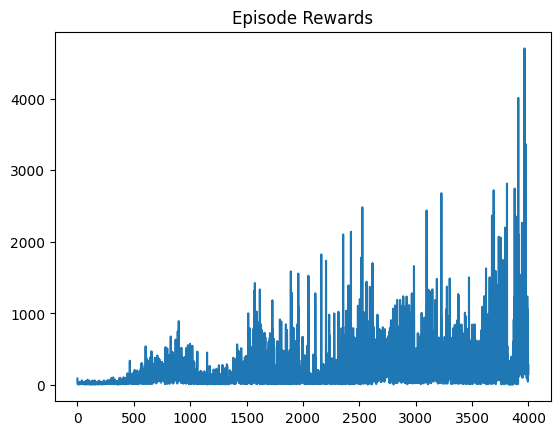

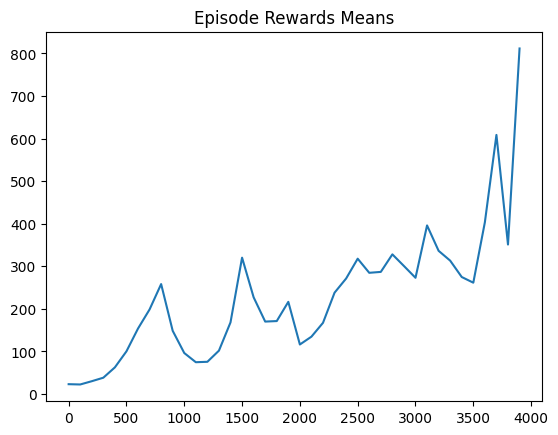

2024-06-13_19-37-45_dqn_cartpole


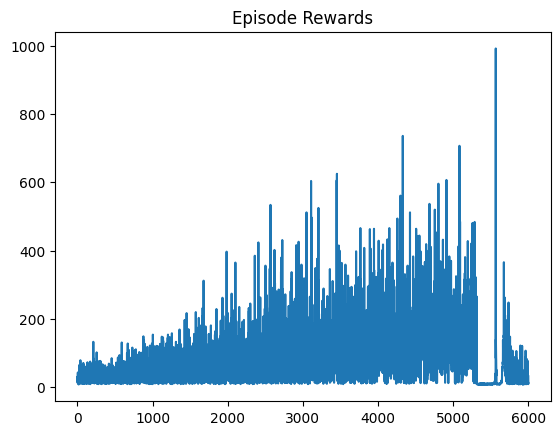

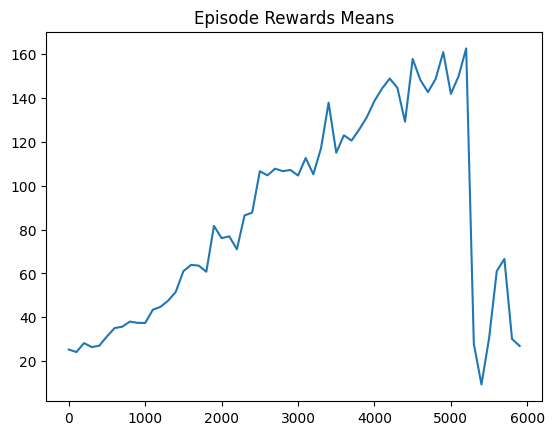

2024-06-13_21-45-52_dqn_cartpole


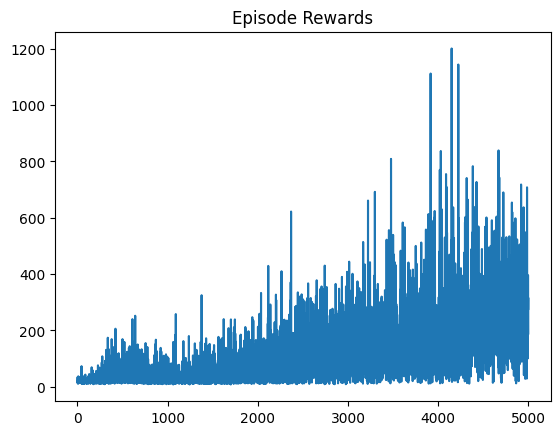

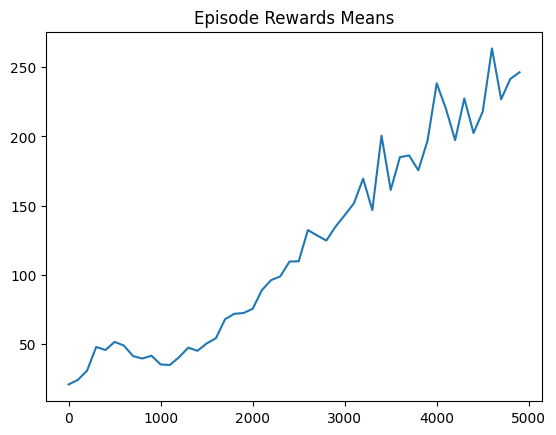

2024-06-13_22-34-12_dqn_cartpole


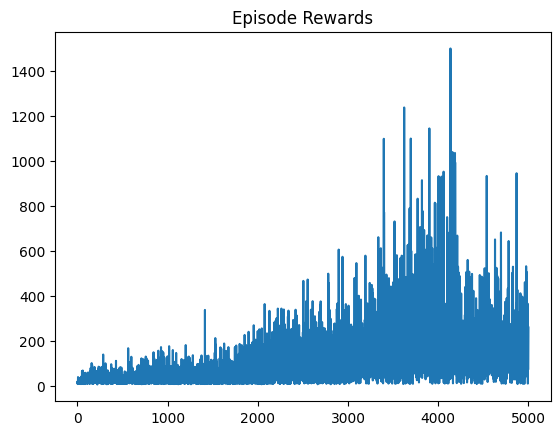

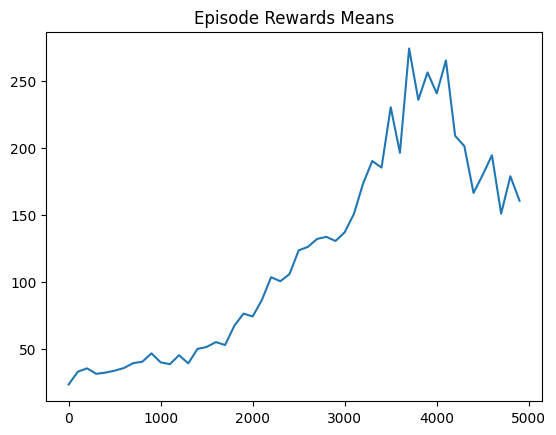

2024-06-13_20-39-12_dqn_cartpole


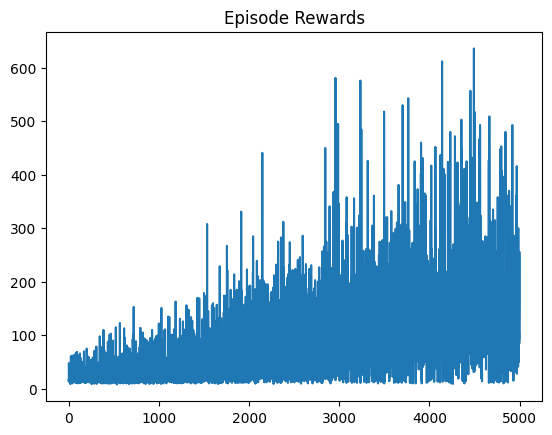

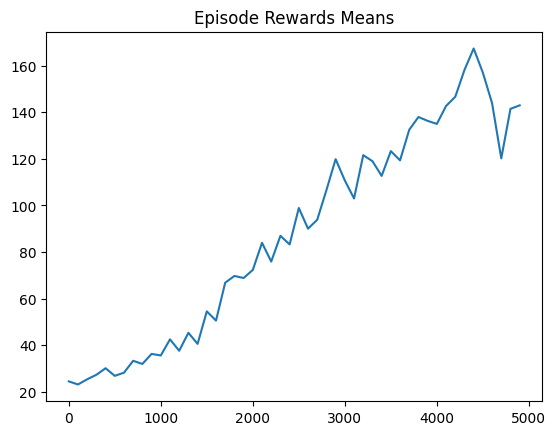

2024-06-14_19-20-40_dqn_cartpole


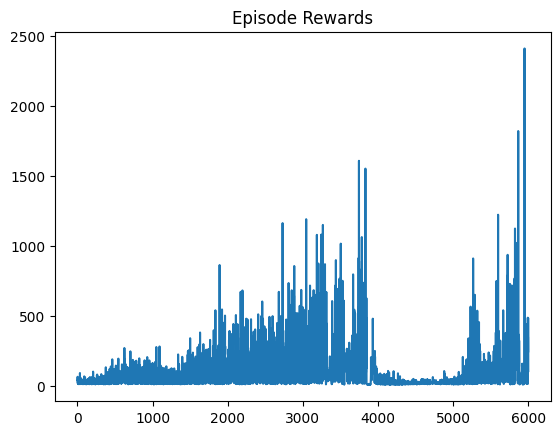

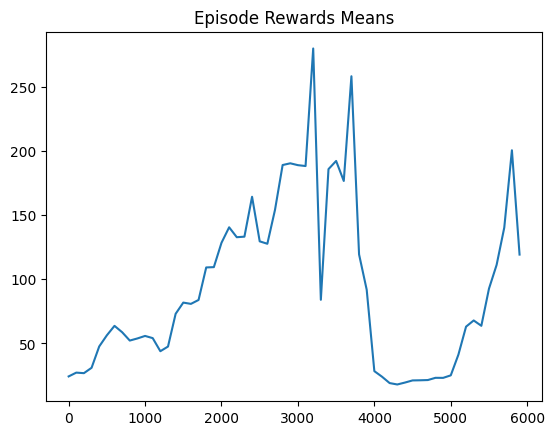

2024-06-14_18-05-51_dqn_cartpole


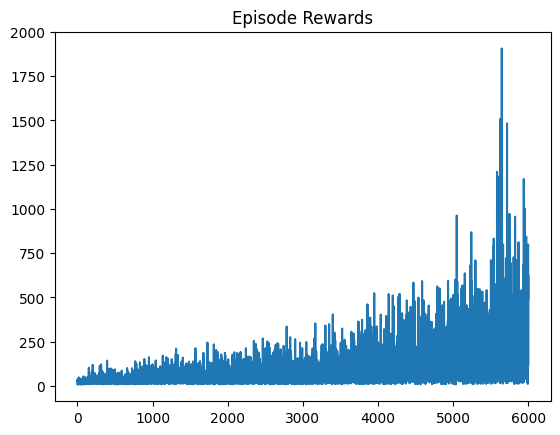

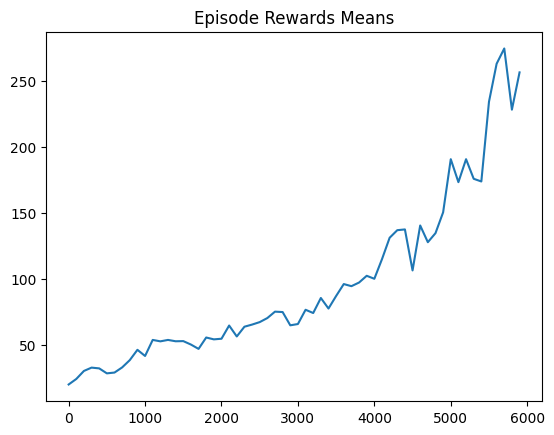

2024-06-14_13-24-09_dqn_cartpole


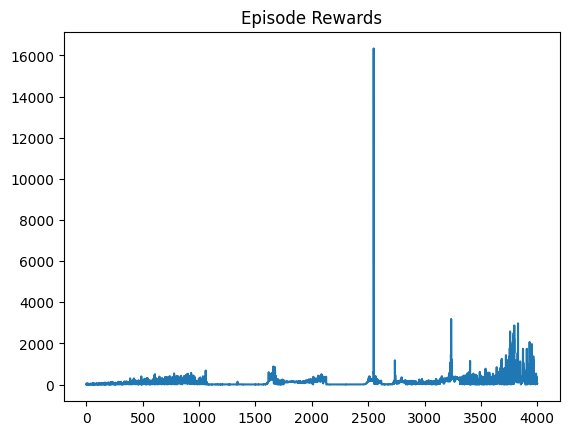

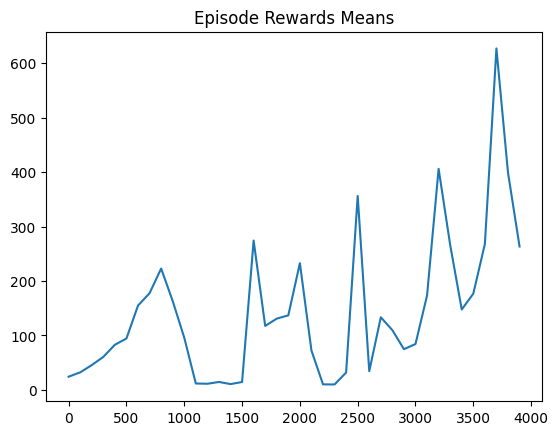

2024-06-13_23-49-30_dqn_cartpole


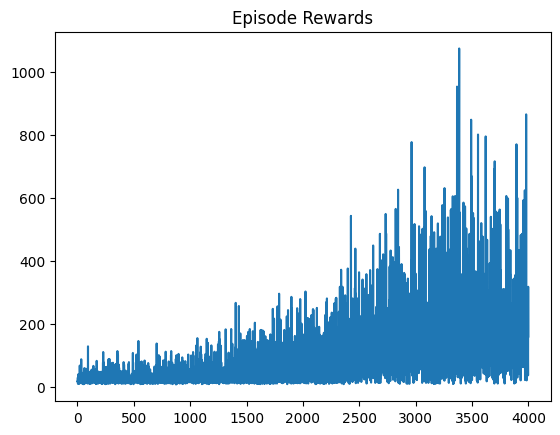

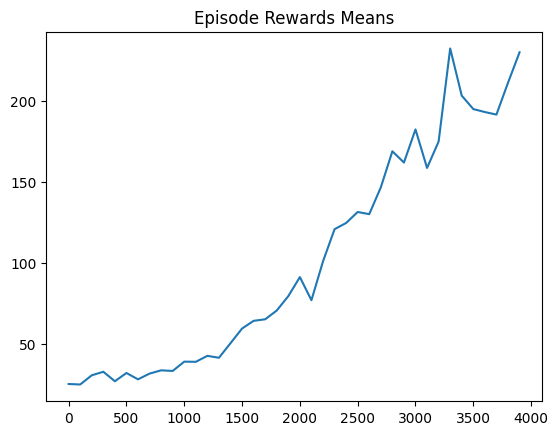

2024-06-14_17-21-25_dqn_cartpole


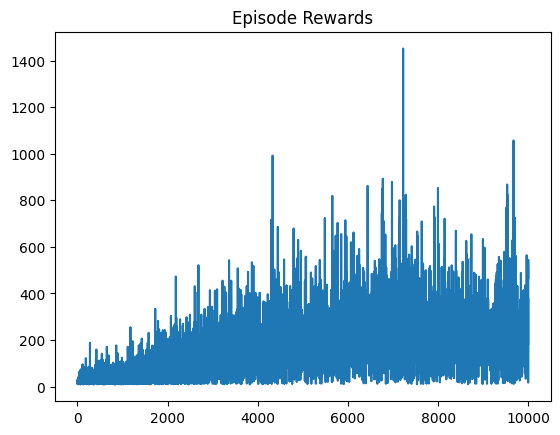

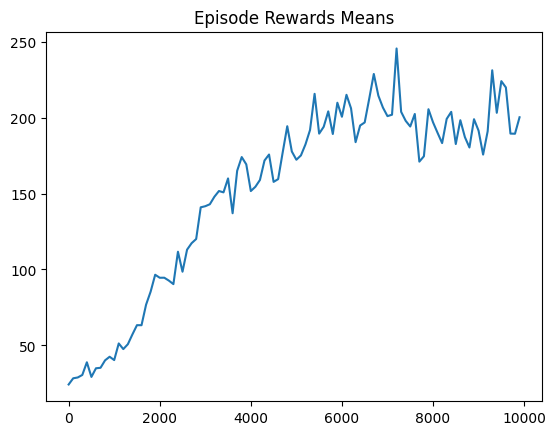

2024-06-13_22-09-48_dqn_cartpole


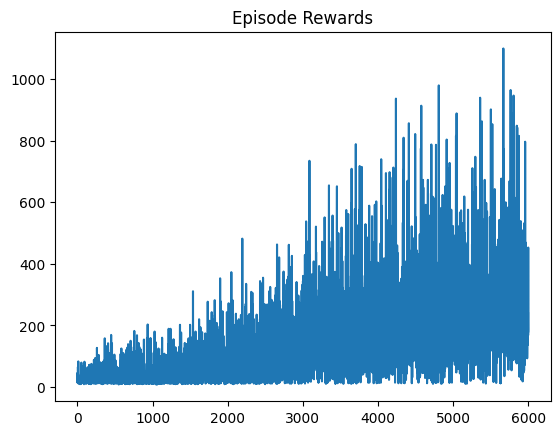

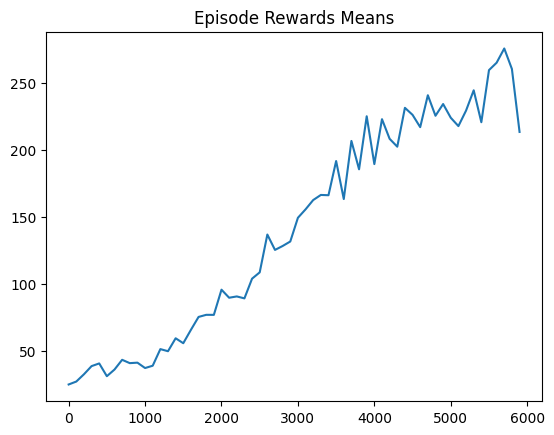

2024-06-13_19-16-11_dqn_cartpole


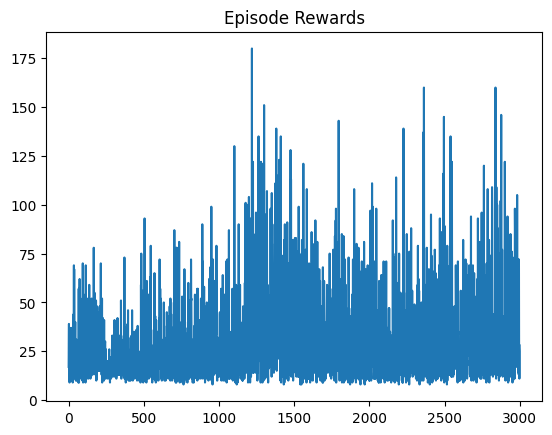

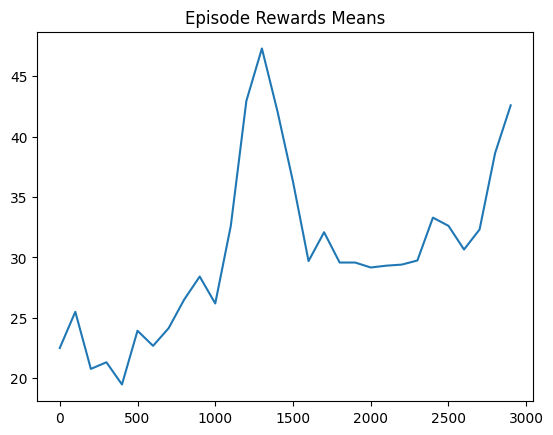

In [9]:
cartpole_models_paths = os.listdir(cartpole_models_path)

data = pd.DataFrame()

for model_name_with_extension in cartpole_models_paths:
    model_name, metrics, hyperparams, model = load_cartpole_model_data(
        model_name_with_extension
    )
    print(model_name)
    evaluate_rewards = evaluate_cartpole_model(model, 1)
    units_per_layer = [layer.units for layer in model.hidden_layers]
    activation_per_layer = [layer.activation.__name__ for layer in model.hidden_layers]
    data = data._append(
        {
            "model": model_name,
            "evaluate_max_reward": np.max(evaluate_rewards),
            "evaluate_rewards_mean": np.mean(evaluate_rewards),
            "evaluate_rewards_std": np.std(evaluate_rewards),
            "hidden_layers": len(model.hidden_layers),
            "units_per_layer": units_per_layer,
            "activation_per_layer": activation_per_layer,
            "output_layer_activation": model.output_layer.activation.__name__,
            **hyperparams,
        },
        ignore_index=True,
    )
    save_metrics(cartpole_results_path, model_name, metrics)

data.to_csv("pole/results.csv")

In [18]:
mountain_data = pd.read_csv("mountain/results.csv")
mountain_data = mountain_data.sort_values(by=["evaluate_max_reward"], ascending=False)
best_mountain_model = mountain_data.iloc[0]
best_mountain_model

Unnamed: 0                                                  19
model                      2024-06-15_13-36-42_dqn_mountaincar
evaluate_max_reward                                      -84.0
evaluate_rewards_mean                                   -104.4
evaluate_rewards_std                                 18.456435
hidden_layers                                                2
units_per_layer                                       [64, 64]
activation_per_layer                          ['relu', 'relu']
output_layer_activation                                 linear
num_episodes                                               200
learning_rate                                            0.001
epsilon                                               0.000983
epsilon_min                                              0.001
epsilon_decay                                             0.95
batch_size                                                  64
discount                                               

In [19]:
pole_data = pd.read_csv("pole/results.csv")
pole_data = pole_data.sort_values(by=["evaluate_max_reward"], ascending=False)
best_pole_model = pole_data.iloc[0]
best_pole_model

Unnamed: 0                                               13
model                      2024-06-14_18-50-42_dqn_cartpole
evaluate_max_reward                                   500.0
evaluate_rewards_mean                                 500.0
evaluate_rewards_std                                    0.0
hidden_layers                                             2
units_per_layer                                    [64, 64]
activation_per_layer                       ['relu', 'relu']
output_layer_activation                              linear
num_episodes                                           6000
learning_rate                                         0.005
epsilon                                            0.014974
epsilon_min                                           0.005
epsilon_decay                                        0.9993
batch_size                                              128
discount                                               0.95
update_target_every                     